# The Wilson-Cowan model

In this notebook, the basic use of the implementation of the Wilson-Cowan (`wc`) model is presented. 

In the `wc` model, the activity of a particular brain region is defined by a coupled system of excitatory (E) and inhibitory (I) neuronal populations with the mean firing rates of the E and I pools being the dynamic variables, as first described by Wilson and Cowan in 1972 ( H.R. Wilson and J.D. Cowan. *Excitatory and inhibitory interactions in localized populations of model neurons*. Biophys. J., 12:1–24 (1972)) 

In [11]:
# change to the root directory of the project
import os
if os.getcwd().split("/")[-1] == "examples":
    os.chdir('..')

In [12]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
import matplotlib.pyplot as plt
import numpy as np
import glob
import scipy
import neurolib.utils.devutils as du

from neurolib.models.wc import WCModel

import neurolib.utils.loadData as ld
import neurolib.utils.functions as func

# a nice color map
plt.rcParams['image.cmap'] = 'plasma'

## Bifurcation diagram

In [14]:
wc = WCModel()
wc.params['duration'] = 2.0*1000
wc.params['exc_ext'] = 0.45
wc.params['c_excinh'] = 10.333333333333334
wc.params['c_inhexc'] = 9.666666666666666
wc.params['c_inhinh'] = 0
wc.params['K_gl'] = 1.843
wc.params['sigma_ou'] = 4.2819e-05

Let's draw a simple one-dimensional bifurcation diagram of this model to orient ourselves in the parameter space

In [15]:
max_exc = []
min_exc = []
# these are the different input values that we want to scan
exc_inputs = np.linspace(0, 3.5, 50)
for exc_ext in exc_inputs:
    # Note: this has to be a vector since it is input for all nodes
    # (but we have only one node in this example)
    wc.params['exc_ext'] = exc_ext
    wc.run()
    # we add the maximum and the minimum of the last second of the 
    # simulation to a list
    max_exc.append(np.max(wc.exc[0, -int(1000/wc.params['dt']):]))
    min_exc.append(np.min(wc.exc[0, -int(1000/wc.params['dt']):]))

Text(0, 0.5, 'Min / max exc')

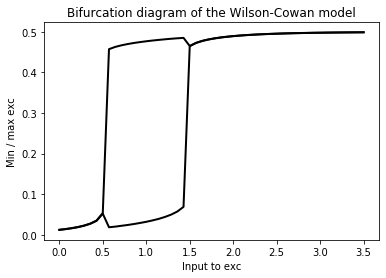

In [16]:
plt.plot(exc_inputs, max_exc, c='k', lw = 2)
plt.plot(exc_inputs, min_exc, c='k', lw = 2)
plt.title("Bifurcation diagram of the Wilson-Cowan model")
plt.xlabel("Input to exc")
plt.ylabel("Min / max exc")

## Single node simulation

In [17]:
import neurolib.utils.functions as func

wc = WCModel()
# control model parameters
wc.params['duration'] = 2 * 1000
wc.params['exc_ext'] = 0.45
wc.params['c_excinh'] = 10.333333333333334
wc.params['c_inhexc'] = 9.666666666666666
wc.params['c_inhinh'] = 0
wc.params['K_gl'] = 1.843
wc.params['sigma_ou'] = 4.2819e-05
wc.run()

exc_tc = wc.outputs.exc[0,:]

frs, powers = func.getPowerSpectrum(
    exc_tc,
    wc.params["dt"],
)

Text(0, 0.5, 'Power')

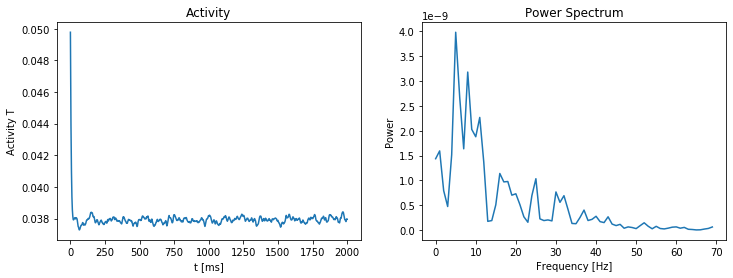

In [18]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].plot(wc.t, wc.exc.T)
axs[0].set_title("Activity")
axs[0].set_xlabel("t [ms]")
axs[0].set_ylabel("Activity T")
axs[1].plot(frs, powers)
axs[1].set_title("Power Spectrum")
axs[1].set_xlabel("Frequency [Hz]")
axs[1].set_ylabel("Power")

## Brain network

In [34]:
from neurolib.utils.loadData import Dataset

ds = Dataset("gw", fcd = True)

MainProcess root INFO     Loading dataset gw from /Users/pamirozsuna/Desktop/Masterarbeit/neurolib/neurolib/utils/../data/datasets/gw.
MainProcess root INFO     Computing FCD matrices ...
MainProcess root INFO     Dataset gw loaded.


In [35]:
wc = WCModel(Cmat = ds.Cmat, Dmat = ds.Dmat)

MainProcess root INFO     wc: Model initialized.


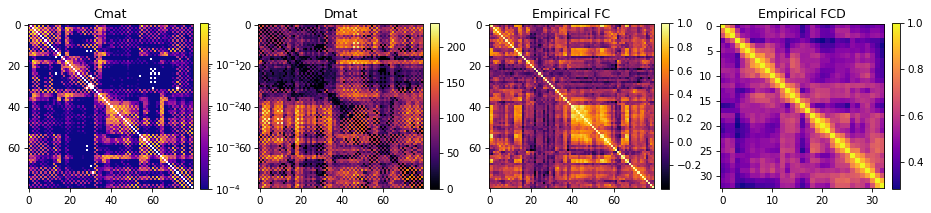

In [36]:
from matplotlib.colors import LogNorm
fig, axs = plt.subplots(1, 4, figsize=(15,12), dpi=75)
fig.subplots_adjust(wspace=0.28)

im = axs[0].imshow(wc.params['Cmat'], norm=LogNorm(vmin=10e-5, vmax=np.max(wc.params['Cmat'])))
axs[0].set_title("Cmat")
fig.colorbar(im, ax=axs[0],fraction=0.046, pad=0.04)
im = axs[1].imshow(wc.params['lengthMat'], cmap='inferno')
axs[1].set_title("Dmat")
fig.colorbar(im, ax=axs[1],fraction=0.046, pad=0.04)
im = axs[2].imshow(ds.FCs[0], cmap='inferno')
axs[2].set_title("Empirical FC")
fig.colorbar(im, ax=axs[2],fraction=0.046, pad=0.04)


im = axs[3].imshow(ds.FCDs[0])
axs[3].set_title("Empirical FCD")
fig.colorbar(im, ax=axs[3],fraction=0.046, pad=0.04)

In [37]:
wc.params['duration'] = 2*1000
wc.params['exc_ext'] = 0.45
wc.params['c_excinh'] = 10.333333333333334
wc.params['c_inhexc'] = 9.666666666666666
wc.params['c_inhinh'] = 0
wc.params['K_gl'] = 1.843
wc.params['sigma_ou'] = 4.2819e-05

wc.run(chunkwise=True, bold = True)

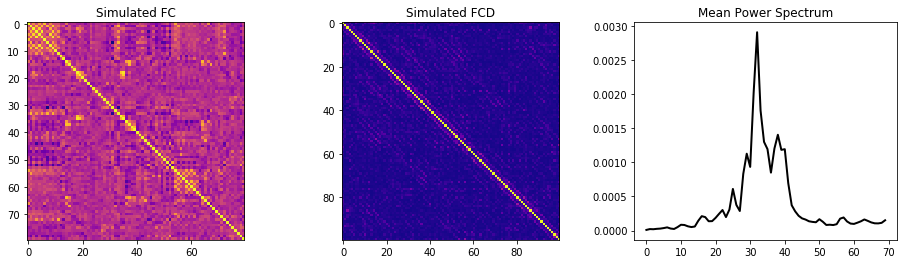

In [38]:
fig, axs = plt.subplots(1, 3, figsize=(16, 4))
axs[0].set_title("Simulated FC")
axs[0].imshow(func.fc(wc.exc[:, -10000:]))
axs[1].set_title("Simulated FCD")
axs[1].imshow(func.fcd(wc.exc[:, -10000:], stepsize=100))
axs[2].set_title("Mean Power Spectrum")
fr, pw = func.getMeanPowerSpectrum(wc.exc, wc.params["dt"])
axs[2].plot(fr, pw, c='k', lw = 2)


In [39]:
scores = [func.matrix_correlation(func.fc(wc.exc[:, -int(5000/wc.params['dt']):]), fcemp) for fcemp in ds.FCs]
print("Correlation per subject:", [f"{s:.2}" for s in scores])
print("Mean FC/FC correlation: {:.2f}".format(np.mean(scores)))

Correlation per subject: ['0.23', '0.28', '0.23', '0.27', '0.33']
Mean FC/FC correlation: 0.27
